In [1]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import plot_hyb
import predict_Beta_I
import seir_discrete
import choice_start_day
import switch
%load_ext autoreload
%autoreload 2

In [2]:
df_orig = pd.read_csv('chel_03_seeds_parameters.csv')
# Чтобы в каждом наборе параметров было минимум 2 файла
# keep = False, чтобы и первые, и последние строки считались за дубликат
dfp = df_orig[df_orig.duplicated(['alpha', 'lambda'], keep=False)]

X = dfp[['file']]
y = dfp[['alpha', 'lambda']]

X_train, X_test = train_test_split(X, test_size=0.2, 
                                   random_state=42, stratify=y)
y = y.loc[X_train.index]
X_train, X_val = train_test_split(X_train, test_size=0.2, 
                                  random_state=42, stratify=y)

X_train_all = pd.concat([X_train, X_val])

X_train.shape, X_test.shape, X_val.shape

((1042, 1), (326, 1), (261, 1))

In [4]:
X_train_all

,file
328,chelyabinsk_0.3_sampled\alpha_0.75_lmbd_0.2_se...
1072,chelyabinsk_0.3_sampled\alpha_0.15_lmbd_0.8_se...
632,chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.3_se...
179,chelyabinsk_0.3_sampled\alpha_0.45_lmbd_0.7_se...
747,chelyabinsk_0.3_sampled\alpha_0.90_lmbd_0.4_se...
...,...
831,chelyabinsk_0.3_sampled\alpha_0.15_lmbd_1.0_se...
880,chelyabinsk_0.3_sampled\alpha_0.65_lmbd_0.5_se...
1541,chelyabinsk_0.3_sampled\alpha_0.65_lmbd_0.6_se...
745,chelyabinsk_0.3_sampled\alpha_0.85_lmbd_0.6_se...


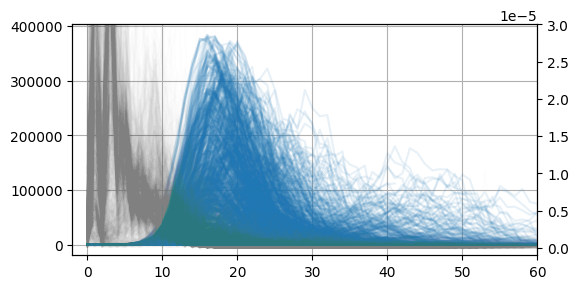

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    ax.plot(df.I_H1N1, color='tab:blue', alpha=0.1)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
        
    ax_b.plot(df[df.beta_H1N1>0]['beta_H1N1'], color='gray', alpha=0.01)
    
plt.xlim(-2, 60)
ax_b.set_ylim(-1e-6, 3e-5)
ax.grid()

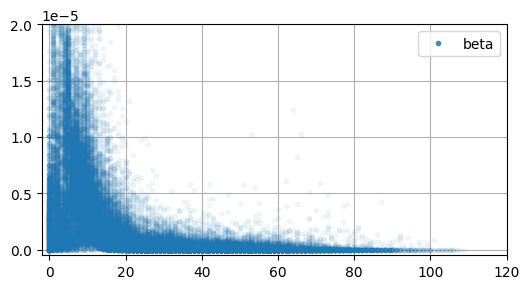

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    ax.plot(df.beta_H1N1, marker='.', ls='', 
              color='tab:blue', alpha=0.05)
    
l1 = ax.plot(df.beta_H1N1, marker='.', ls='', 
              color='tab:blue', alpha=0.1, label='beta')  

labs = [l.get_label() for l in l1]
leg = ax.legend(l1, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)

plt.xlim(-2, 120)
plt.ylim(-5e-7, 2e-5)

ax.grid()

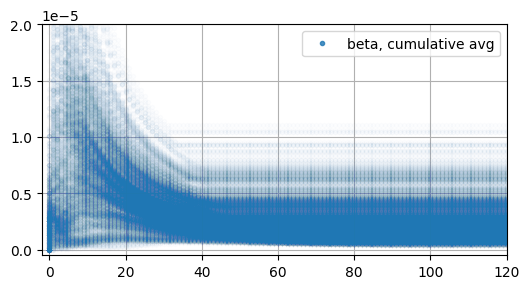

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    ax.plot(df.beta_H1N1.expanding().mean(), marker='.', ls='', 
              color='tab:blue', alpha=0.01)


l1 = ax.plot(df.beta_H1N1.expanding().mean(), marker='.', ls='', 
              color='tab:blue', alpha=0.1, label='beta, cumulative avg')  

labs = [l.get_label() for l in l1]
leg = ax.legend(l1, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)
    
plt.xlim(-2, 120)
plt.ylim(-5e-7, 2e-5)    
ax.grid()

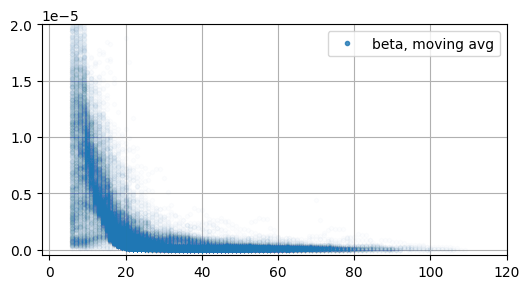

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    ax.plot(df.beta_H1N1.rolling(7).mean(), marker='.', ls='', 
              color='tab:blue', alpha=0.01)


l1 = ax.plot(df.beta_H1N1.rolling(7).mean(), marker='.', ls='', 
              color='tab:blue', alpha=0.1, label='beta, moving avg')  

labs = [l.get_label() for l in l1]
leg = ax.legend(l1, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)
    
plt.xlim(-2, 120)
plt.ylim(-5e-7, 2e-5)    
ax.grid()

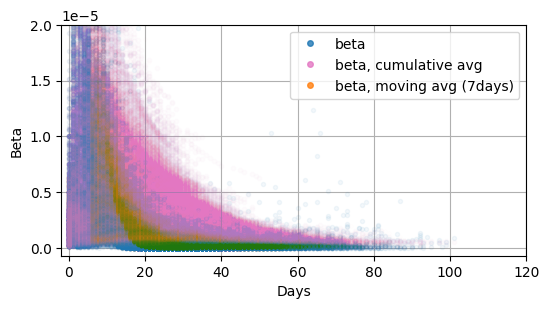

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
        
    ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'], marker='.', ls='', 
              color='tab:blue', alpha=0.05)
    
l1 = ax.plot(df.beta_H1N1, marker='.', ls='', 
              color='tab:blue', alpha=0., label='beta', markersize=8)  


for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
        
    ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].expanding().mean(), marker='.', ls='', 
              color='tab:pink', alpha=0.02)
    
l2 = ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].expanding().mean(), marker='.', ls='', 
              color='tab:pink', alpha=0., 
             label='beta, cumulative avg', markersize=8)  


for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
    ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].rolling(7).mean(), marker='.', ls='', 
              color='tab:orange', alpha=0.005)
    
l3 = ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].rolling(7).mean(), marker='.', ls='', 
              color='tab:orange', alpha=0., 
             label='beta, moving avg (7days)', markersize=8)  

lns = l1+l2+l3
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)

plt.xlim(-2, 120)
plt.ylim(-7e-7, 2e-5)
plt.xlabel('Days')
plt.ylabel('Beta')
ax.grid()

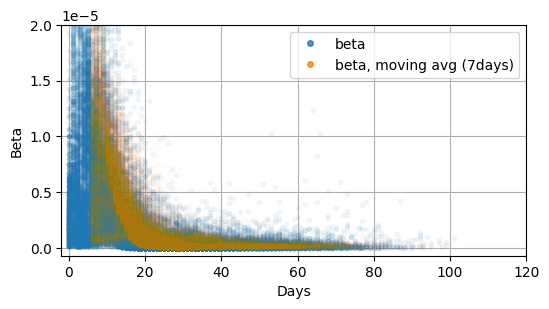

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
        
    ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'], marker='.', ls='', 
              color='tab:blue', alpha=0.05)
    
l1 = ax.plot(df.beta_H1N1, marker='.', ls='', 
              color='tab:blue', alpha=0., label='beta', markersize=8)  


for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
    ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].rolling(7).mean(), marker='.', ls='', 
              color='tab:orange', alpha=0.01)
    
l3 = ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].rolling(7).mean(), marker='.', ls='', 
              color='tab:orange', alpha=0., 
             label='beta, moving avg (7days)', markersize=8)  

lns = l1+l3
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)

plt.xlim(-2, 120)
plt.ylim(-7e-7, 2e-5)
plt.xlabel('Days')
plt.ylabel('Beta')
ax.grid()

## пересчет беты?

In [19]:
df.iloc[:10]

,S_H1N1,E_H1N1,I_H1N1,R_H1N1,beta_H1N1
0,437415.0,10.0,10.0,357901.0,6.858475e-07
1,437412.0,13.0,10.0,357901.0,2.514792e-06
2,437401.0,14.0,20.0,357901.0,1.943297e-06
3,437384.0,28.0,23.0,357901.0,2.683941e-06
4,437357.0,44.0,34.0,357901.0,2.555457e-06
5,437319.0,65.0,51.0,357901.0,3.586918e-06
6,437239.0,118.0,68.0,357911.0,5.381362e-06
7,437079.0,240.0,106.0,357911.0,6.367313e-06
8,436784.0,455.0,176.0,357921.0,4.201682e-06
9,436461.0,618.0,333.0,357924.0,3.667225e-06


In [ ]:
S_eq_0 = df[df.S_H1N1==0].index
    if S_eq_0.shape[0]>1:

In [39]:
df.iloc[0:5]

,S_H1N1,E_H1N1,I_H1N1,R_H1N1,beta_H1N1
0,437415.0,10.0,10.0,357901.0,6.858475e-07
1,437412.0,13.0,10.0,357901.0,2.514792e-06
2,437401.0,14.0,20.0,357901.0,1.943297e-06
3,437384.0,28.0,23.0,357901.0,2.683941e-06
4,437357.0,44.0,34.0,357901.0,2.555457e-06


In [53]:
(437415-437384)

31

In [59]:
31/(437401*20)

3.543659022270182e-06

In [58]:
expb[:5]

0    6.858475e-07
1    3.200644e-06
2    3.543659e-06
3    5.765504e-06
4    6.455892e-06
dtype: float64

In [51]:
df.S_H1N1[:-1]

0      437415.0
1      437412.0
2      437401.0
3      437384.0
4      437357.0
         ...   
244         0.0
245         0.0
246         0.0
247         0.0
248         0.0
Name: S_H1N1, Length: 249, dtype: float64

In [52]:
df.I_H1N1[:-1]

0      10.0
1      10.0
2      20.0
3      23.0
4      34.0
       ... 
244     0.0
245     0.0
246     0.0
247     0.0
248     0.0
Name: I_H1N1, Length: 249, dtype: float64

In [50]:
df.S_H1N1.diff().expanding().sum()[1:].reset_index(drop=True)

0          -3.0
1         -14.0
2         -31.0
3         -58.0
4         -96.0
         ...   
244   -437415.0
245   -437415.0
246   -437415.0
247   -437415.0
248   -437415.0
Name: S_H1N1, Length: 249, dtype: float64

In [41]:
expb[:5]

0    6.858475e-07
1    3.200644e-06
2    3.543659e-06
3    5.765504e-06
4    6.455892e-06
dtype: float64

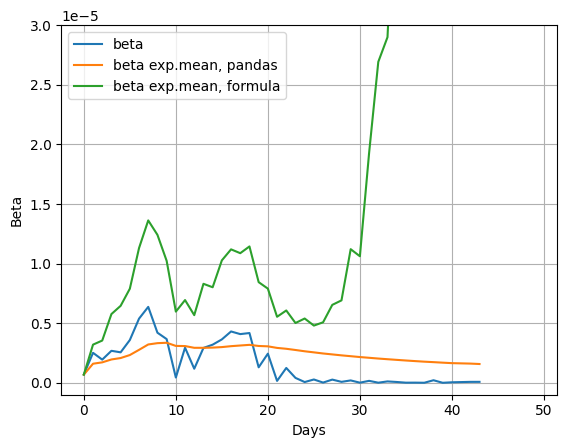

In [67]:
plt.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'], label='beta')
plt.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].expanding().mean(), 
         label='beta exp.mean, pandas')
expb = -df.S_H1N1.diff().expanding().sum()[1:].reset_index(drop=True
                                                            )  / (df.S_H1N1[:-1]*df.I_H1N1[:-1])
S_eq_0 = df[df.S_H1N1==0].index
if S_eq_0.shape[0]>1:
    # тк последняя бета будет учитывать следующую delta S (450k-0)
    expb = expb[:S_eq_0[0]-2]
    
plt.plot(expb, label='beta exp.mean, formula')
#plt.ylim(-0.01, 0.1)
plt.legend()

plt.xlabel('Days')
plt.ylabel('Beta')
plt.ylim(-1e-6, 3e-5)
plt.grid()

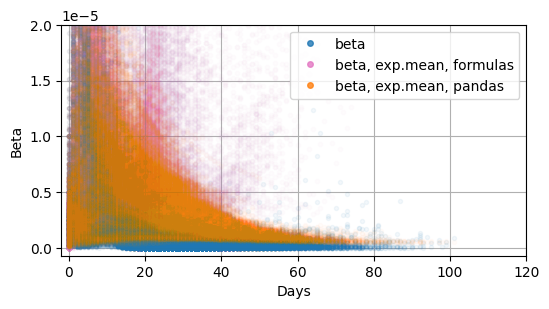

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
        
    ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'], marker='.', ls='', 
              color='tab:blue', alpha=0.05)
    
l1 = ax.plot(df.beta_H1N1, marker='.', ls='', 
              color='tab:blue', alpha=0., label='beta', markersize=8)  


for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
    expb = -df.S_H1N1.diff().expanding().sum()[1:].reset_index(drop=True
                                                            )  / (df.S_H1N1[:-1]*df.I_H1N1[:-1])
    S_eq_0 = df[df.S_H1N1==0].index
    if S_eq_0.shape[0]>1:
        # тк последняя бета будет учитывать следующую delta S (450k-0)
        expb = expb[:S_eq_0[0]-2]
    
    ax.plot(expb, marker='.', ls='', 
              color='tab:pink', alpha=0.02)
    
l2 = ax.plot(expb, marker='.', ls='', 
              color='tab:pink', alpha=0., 
             label='beta, exp.mean, formulas', markersize=8)  


for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    epidemic_end = df[(df['E_H1N1'] == 0) & (df['I_H1N1'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'beta_H1N1'] = -1
        
    ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].expanding().mean(), marker='.', ls='', 
              color='tab:orange', alpha=0.02)
    
l3 = ax.plot(df.loc[df['beta_H1N1']>0, 'beta_H1N1'].expanding().mean(), marker='.', ls='', 
              color='tab:orange', alpha=0., 
             label='beta, exp.mean, pandas', markersize=8)  

lns = l1+l2+l3
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)

plt.xlim(-2, 120)
plt.ylim(-7e-7, 2e-5)
plt.xlabel('Days')
plt.ylabel('Beta')
ax.grid()

0.08461538461538462

In [ ]:
all_betas = pd.DataFrame()
for i in np.arange(960):
    df = pd.read_csv(f'train/seir_seed_{i}.csv')
    '''
    epidemic_end = df[(df['E'] == 0) & (df['I'] == 0)].index
    if epidemic_end.shape[0]>1:
        df.loc[epidemic_end[1]:,'Beta'] = -2
    '''
    all_betas = pd.concat([all_betas, df[['Beta']]], axis=1)


fig = plt.figure(figsize=(6, 4)) 
plt.plot(all_betas.iloc[0,0], marker='.', ls='',alpha=0.5,
        label='Train data')
plt.plot(all_betas[all_betas>0], marker='.', ls='',alpha=0.01,
        color='tab:blue');

plt.legend()
plt.xlabel('Day')
plt.ylabel('Beta')
plt.ylim(0,1e-5)
plt.legend()
plt.savefig(f'results/Beta_trajectories_expm.pdf', format='pdf',  bbox_inches='tight') 